### Imports

In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
import warnings
import copy

warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')

### Configs

Será utilizados um dicionário para categorizar os estados, casa estado receberá um número condizente com seu PIB, sendo os maiores números os maiores PIBs e os menores números os menores PIBs.

Fonte: https://www.ibge.gov.br/explica/pib.php

In [2]:
# Dicionário para o enconding estadual
uf_dict = {'SP':28, 'RJ':27, 'MG':26, 'RS':25, 'PR':24, 'SC':23, 'DF':22, 'BA':21, 'GO':20, 'PE':19,
           'ES':18, 'PA':17, 'CE':16, 'MT':15, 'AM':14, 'MA':13, 'MS':12, 'RN':11, 'PB':10, 'AL': 9,
           'RO': 8, 'SE': 7, 'PI': 6, 'TO': 5, 'AP': 4, 'AC': 3, 'RR': 2, 'DE':1}

# file paths
pre_model_path = '..\data\dados_pre_model.csv'
model_file_path = r'..\model\finalized_model.sav'
after_model_path = '..\data\dados_after_model.csv'

### Modelagem, Avaliação e Otimização

In [3]:
df = pd.read_csv(pre_model_path); df.head()

,Município,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000","Índice de Gini, 2000",...,"Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000",Estado
0,Abadia de Goiás (GO),136.9,36.3,21.414308,67.58,27.70,2.85,15.64,205.27,0.53,...,4.87,1872,2433,121,227,4227,4971,3096,1875,GO
1,Abadia dos Dourados (MG),897.4,7.2,390.876513,72.92,20.51,2.54,14.48,196.36,0.52,...,4.36,3308,3781,354,459,6492,6446,3927,2519,MG
2,Abadiânia (GO),1047.7,10.9,78.641435,69.59,22.36,2.77,21.81,168.31,0.56,...,4.24,4241,5918,446,686,9402,11452,7206,4246,GO
3,Abaetetuba (PA),1613.9,73.8,51.184552,70.77,25.61,3.15,24.85,102.14,0.59,...,4.28,33554,44897,3792,4688,99989,119152,70843,48309,PA
4,Abaeté (MG),1822.4,12.3,172.311549,72.50,21.59,2.41,15.56,253.68,0.58,...,4.78,10163,12406,1084,1595,20689,22360,19022,3338,MG


In [4]:
# Transformando a coluna estado em dado categórico e removendo a coluna nome dos Municípios, uma vez que não será útil para modelagem
dados=copy.deepcopy(df)
dados.drop('Município',axis=1, inplace=True)
dados['Estado'] = dados['Estado'].apply(lambda x: uf_dict[x])

In [5]:
# Modelagem
dados = dados.values
pca = PCA(n_components=2).fit_transform(dados)

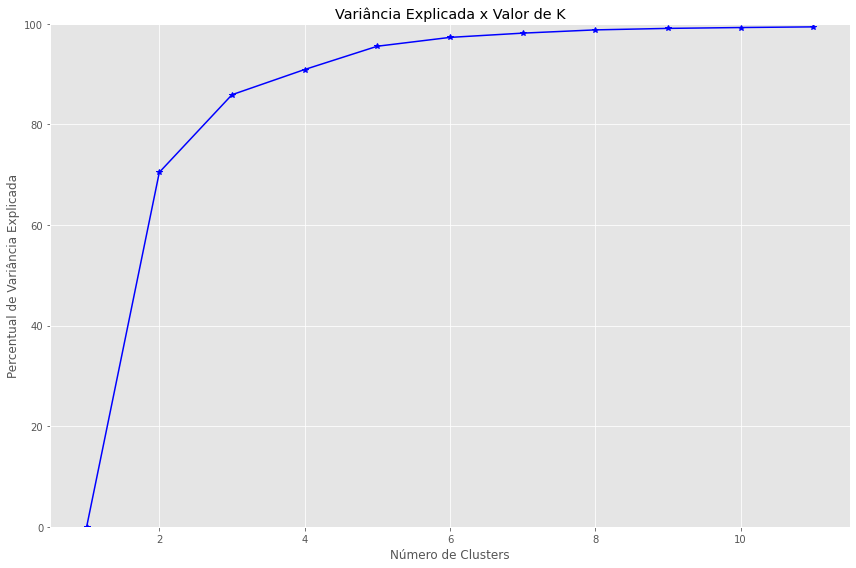

In [6]:
# Definindo o tamanho dos gráficos
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

# Determinando um range de K
k_range = range(1,12)

# Aplicando o modelo K-Means para cada valor de K (esta célula pode levar bastante tempo para ser executada)
k_means_var = [KMeans(n_clusters = k).fit(dados) for k in k_range]

# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(dados, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

# Soma total dos quadrados
soma_total = sum(pdist(dados)**2)/dados.shape[0]

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

# Plotando o resultado
plt.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax = plt.gca()
ax.set_ylim([0,100])
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

fig.tight_layout()
plt.show()

Esse gráfico nos da uma visão geral dos valores otimizados de K a serem utilizados, nitidamente os valores de K abaixo de 6 não conseguem explicar a maioria da variância entre os dados.

A partir do exposto acima, será feita uma análise para verificar qual o valor ótimo de clusters para que não ocorra sobreposição de grupos.

In [7]:
# Criando um modelo com K = 6, 7, 8, 9, 10, 11 e 12
modelos = dict()

# Treinando os Modelos
for i in range(6,13):
    m = KMeans(n_clusters = i)
    modelos.update({'modelo_k'+str(i) : m.fit(dados)})

# Print dos Resultados
for key in modelos.keys():
    labels = modelos[key].labels_
    print(key,": ",silhouette_score(dados, labels, metric = 'euclidean'))

modelo_k6 :  0.8808651497132565
modelo_k7 :  0.8780126217264247
modelo_k8 :  0.7763482880513183
modelo_k9 :  0.7650982292667928
modelo_k10 :  0.7222056250942999
modelo_k11 :  0.6241106520994362
modelo_k12 :  0.6024998801356201


Visto os resultados expostos acima, o número de clusters escolhido será K=7, ou seja, dividiremos os municípios em 7 grupos diferentes

In [8]:
model = modelos['modelo_k7']

In [9]:
df['Grupo'] = model.labels_
df['Grupo'] = df['Grupo'].apply(lambda x: 'Grupo '+str(x+1))
df.head()

,Município,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000","Índice de Gini, 2000",...,"População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000",Estado,Grupo
0,Abadia de Goiás (GO),136.9,36.3,21.414308,67.58,27.70,2.85,15.64,205.27,0.53,...,1872,2433,121,227,4227,4971,3096,1875,GO,Grupo 1
1,Abadia dos Dourados (MG),897.4,7.2,390.876513,72.92,20.51,2.54,14.48,196.36,0.52,...,3308,3781,354,459,6492,6446,3927,2519,MG,Grupo 1
2,Abadiânia (GO),1047.7,10.9,78.641435,69.59,22.36,2.77,21.81,168.31,0.56,...,4241,5918,446,686,9402,11452,7206,4246,GO,Grupo 1
3,Abaetetuba (PA),1613.9,73.8,51.184552,70.77,25.61,3.15,24.85,102.14,0.59,...,33554,44897,3792,4688,99989,119152,70843,48309,PA,Grupo 7
4,Abaeté (MG),1822.4,12.3,172.311549,72.50,21.59,2.41,15.56,253.68,0.58,...,10163,12406,1084,1595,20689,22360,19022,3338,MG,Grupo 1


In [10]:
df_teste = copy.deepcopy(df.drop('Município', axis=1))
df_teste['Estado'] = df_teste['Estado'].apply(lambda x: uf_dict[x])
df_teste.drop('Grupo',axis=1, inplace=True)
df_teste_values = df_teste.values

In [11]:
df_teste['Grupo'] = model.predict(df_teste.values)

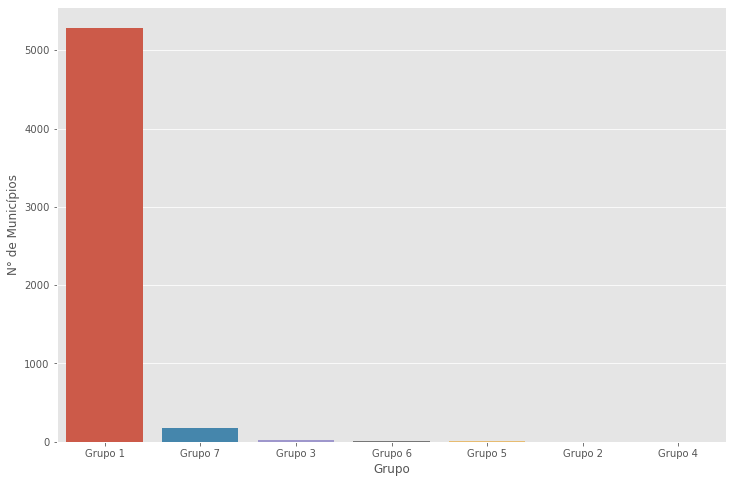

In [12]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

sns.countplot(x=df['Grupo'])

plt.ylabel('N° de Municípios')
plt.show()

In [13]:
df['Grupo'].value_counts()

Grupo 1    5288
Grupo 7     175
Grupo 3      28
Grupo 6      10
Grupo 5       4
Grupo 2       1
Grupo 4       1
Name: Grupo, dtype: int64

### Salvando o modelo e o DataFrame Resultante

In [14]:
joblib.dump(model, model_file_path)
df.to_csv(after_model_path, index=False)